In [15]:
import pandas as pd
import os
import csv

directory = "C:/Users/pillya/Documents/ish/vkr/datasets"

for filename in os.listdir(directory):
    if filename.endswith('.tsv'):
        tsv_file = os.path.join(directory, filename)
        csv_file = os.path.join(directory, filename.replace('.tsv', '.csv'))
        with open(tsv_file, 'r', newline='', encoding='utf-8') as infile, open(csv_file, 'w', newline='', encoding='utf-8') as outfile:
            reader = csv.reader(infile, delimiter='\t')
            writer = csv.writer(outfile)
            for row in reader:
                writer.writerow(row)
        print(f'Converted {tsv_file} to {csv_file}')

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        try:
            df = pd.read_csv(file_path, header=None)
            df.columns = ['text', 'value']  
            df.to_csv(file_path, index=False)
            print(f'Successfully processed and overwritten {filename}')
        except PermissionError as e:
            print(f"Permission error for {filename}: {e}")
        except FileNotFoundError as e:
            print(f"File not found: {e}")
        except Exception as e:
            print(f"An error occurred while processing {filename}: {e}")

Converted C:/Users/pillya/Documents/ish/vkr/datasets\ger.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\ger.csv
Converted C:/Users/pillya/Documents/ish/vkr/datasets\gre.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\gre.csv
Converted C:/Users/pillya/Documents/ish/vkr/datasets\rus.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\rus.csv
Converted C:/Users/pillya/Documents/ish/vkr/datasets\tur.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\tur.csv
Successfully processed and overwritten ger.csv
Successfully processed and overwritten gre.csv
Successfully processed and overwritten rus.csv
Successfully processed and overwritten tur.csv


In [16]:
def load_dataset(file_path):
    return pd.read_csv(file_path)

def clean_dataset(df):
    return df

languages = ['ger', 'gre', 'tur', 'rus']
datasets = []

for lang in languages:
    file_path = os.path.join(directory, f'{lang}.csv')
    try:
        df = load_dataset(file_path)
        df = clean_dataset(df)
        datasets.append(df)
        print(f'Очистка прошла успешно {file_path}')
    except PermissionError as e:
        print(f"Permission error: {e}")
    except FileNotFoundError as e:
        print(f"File not found: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

Очистка прошла успешно C:/Users/pillya/Documents/ish/vkr/datasets\ger.csv
Очистка прошла успешно C:/Users/pillya/Documents/ish/vkr/datasets\gre.csv
Очистка прошла успешно C:/Users/pillya/Documents/ish/vkr/datasets\tur.csv
Очистка прошла успешно C:/Users/pillya/Documents/ish/vkr/datasets\rus.csv


In [17]:
combined_df = pd.concat(datasets, keys=languages, names=['language', 'index'])
combined_df = combined_df.reset_index(level=1, drop=True).reset_index()

In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42, stratify=combined_df['language'])

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("TrainDF columns:", train_df.columns)
print("TestDF columns:", test_df.columns)

print("TrainDF head:\n", train_df.head())
print("TestDF head:\n", test_df.head())

if '1.' in train_df.columns:
    train_df.rename(columns={'1.': 'text'}, inplace=True)
if '1.' in test_df.columns:
    test_df.rename(columns={'1.': 'text'}, inplace=True)
if 'text' not in train_df.columns:
    raise KeyError("Столбец 'text' не найден в train_df")
if 'text' not in test_df.columns:
    raise KeyError("Столбец 'text' не найден в test_df")

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['text'].dropna())
X_test = vectorizer.transform(test_df['text'].dropna())
y_train = train_df['language']
y_test = test_df['language']
print("Векторизация выполнена успешно")

TrainDF columns: Index(['language', 'text', 'value'], dtype='object')
TestDF columns: Index(['language', 'text', 'value'], dtype='object')
TrainDF head:
        language   text     value
145968      rus      .         O
34520       ger   auch         O
87990       gre   Σάσα  B-PERSON
143087      rus  будет         O
46530       ger    den         O
TestDF head:
        language            text value
34016       ger    eingebettete     O
77103       gre  χαρακτηριστικό     O
6710        ger         Urteils     O
102573      gre             για     O
102757      gre             που     O
Векторизация выполнена успешно


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ger       0.56      1.00      0.71     12879
         gre       0.99      0.51      0.67      8027
         rus       0.97      0.29      0.45      5826
         tur       0.97      0.38      0.55      3583

    accuracy                           0.66     30315
   macro avg       0.87      0.54      0.59     30315
weighted avg       0.80      0.66      0.63     30315



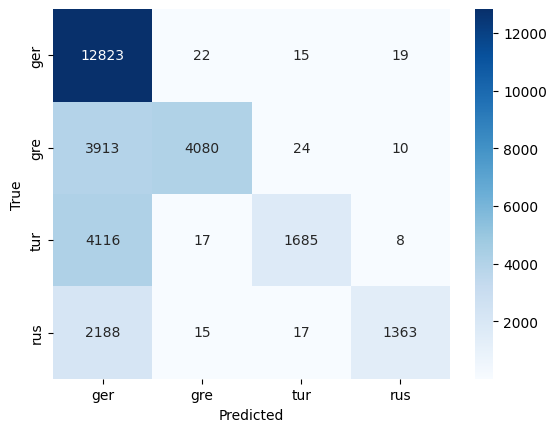

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=languages, yticklabels=languages)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
import joblib

joblib.dump(model, 'language_classifier.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [23]:
model = joblib.load('language_classifier.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

def predict_language(text):
    text_vectorized = vectorizer.transform([text])
    predicted_language = model.predict(text_vectorized)[0]
    return predicted_language

def main():
    print("Введите несколько слов на любом языке, и модель предскажет язык:")
    user_input = input("Ввод: ")
    predicted_language = predict_language(user_input)
    print(f"Предсказанный язык: {predicted_language}")

if __name__ == "__main__":
    main()

Введите несколько слов на любом языке, и модель предскажет язык:
Предсказанный язык: ger


In [24]:
# Проверка данных
print(combined_df.head(10))
print(combined_df['language'].value_counts())

  language         text value
0      ger           1.     O
1      ger          Auf     O
2      ger          die     O
3      ger     Revision     O
4      ger          des     O
5      ger  Angeklagten     O
6      ger         wird     O
7      ger          das     O
8      ger       Urteil     O
9      ger          der     O
language
ger    64397
gre    40133
rus    29131
tur    17914
Name: count, dtype: int64


In [25]:
sample_text = "Доброе утро"
sample_vectorized = vectorizer.transform([sample_text])
print(sample_vectorized.toarray())

[[0. 0. 0. ... 0. 0. 0.]]


In [26]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ger       0.56      1.00      0.71     12879
         gre       0.99      0.51      0.67      8027
         rus       0.97      0.29      0.45      5826
         tur       0.97      0.38      0.55      3583

    accuracy                           0.66     30315
   macro avg       0.87      0.54      0.59     30315
weighted avg       0.80      0.66      0.63     30315



In [27]:
for i in range(5):
    sample_text = test_df['text'].iloc[i]
    sample_vectorized = vectorizer.transform([sample_text])
    predicted_language = model.predict(sample_vectorized)[0]
    true_language = test_df['language'].iloc[i]
    print(f"Text: {sample_text}\nTrue Language: {true_language}\nPredicted Language: {predicted_language}\n")

Text: eingebettete
True Language: ger
Predicted Language: ger

Text: χαρακτηριστικό
True Language: gre
Predicted Language: ger

Text: Urteils
True Language: ger
Predicted Language: ger

Text: για
True Language: gre
Predicted Language: gre

Text: που
True Language: gre
Predicted Language: gre



In [28]:
def predict_language(text):
    text_vectorized = vectorizer.transform([text])
    predicted_language = model.predict(text_vectorized)[0]
    return predicted_language


user_input = "Россия"
predicted_language = predict_language(user_input)
print(f"Предсказанный язык: {predicted_language}")

Предсказанный язык: rus
